In [54]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import gym
import matplotlib.pyplot as plt
import random
import argparse
from collections import OrderedDict
from copy import copy
# import Learn_Knonlinear as lka
import scipy
import scipy.linalg
from scipy.integrate import odeint
import sys
import os
sys.path.append("../utility")
sys.path.append("../train")
from Utility import data_collecter
os.environ['KMP_DUPLICATE_LIB_OK'] = "TRUE"

In [55]:
Methods = ["KoopmanDerivative","KoopmanRBF",\
            "KNonlinear","KNonlinearRNN","KoopmanU",\
            "KoopmanNonlinearA","KoopmanNonlinear",\
            "DKNGU",
                ]
Method_names = ["KoopmanDerivative","KoopmanRBF",\
            "KDNN","KRNN","DKUC",\
            "DKAC","DKN", "MC-DKN(ours)"
                ]
suffixes =["4_28", "4_30", "5_2", "5_2", "5_2", "5_2_ode_constraint"]

In [56]:
def eval_err(suffix,env_name,method_index):
    # method_index = 0
    method = Methods[method_index]
    root_path = "../Data/"+suffix
    print(method)
    if method.endswith("KNonlinear"):
        import Learn_Knonlinear as lka
    elif method.endswith("KNonlinearRNN"):
        import Learn_Knonlinear_RNN as lka
    elif method.endswith("KoopmanNonlinear"):
        import Learn_KoopmanNonlinear_with_KlinearEig as lka
    elif method.endswith("KoopmanNonlinearA"):
        import Learn_KoopmanNonlinearA_with_KlinearEig as lka
    elif method.endswith("KoopmanU"):
        import Learn_Koopman_with_KlinearEig as lka
    elif method.endswith("KoopmanAE"):
        import Learn_KoopmanAE_with_KlinearEig as lka
    elif method.endswith("DKNGU"):
        import Learn_DKN_gxu as lka
    for file in os.listdir(root_path):
        if file.startswith(method+"_"+env_name) and file.endswith("samples20000.pth"):
            model_path = file  
    if method.endswith("DKNGU"):
        for file in os.listdir(root_path):
            if file.startswith(method+"_"+env_name) and file.endswith("samples20000_geom0.1.pth"):
                model_path = file
    Data_collect = data_collecter(env_name)
    udim = Data_collect.udim
    Nstates = Data_collect.Nstates
    layer_depth = 3
    layer_width = 128
    dicts = torch.load(root_path+"/"+model_path,map_location=torch.device('cpu'))
    state_dict = dicts["model"]
    if method.endswith("KNonlinear"):
        Elayer = dicts["Elayer"]
        net = lka.Network(layers=Elayer,u_dim=udim, device="cpu")
    elif method.endswith("KNonlinearRNN"):
        net = lka.Network(input_size=udim+Nstates,output_size=Nstates,hidden_dim=layer_width, n_layers=layer_depth-1, device="cpu")
    elif method.endswith("KoopmanNonlinear") or method.endswith("KoopmanNonlinearA"):
        layer = dicts["layer"]
        blayer = dicts["blayer"]
        NKoopman = layer[-1]+Nstates
        net = lka.Network(layer,blayer,NKoopman,udim, device="cpu")
    elif method.endswith("KoopmanU"):
        layer = dicts["layer"]
        NKoopman = layer[-1]+Nstates
        net = lka.Network(layer,NKoopman,udim, device="cpu")  
    elif method.endswith("KoopmanAE"):
        layer = dicts["layer"]
        dlayer = dicts["dlayer"]
        NKoopman = layer[-1]
        net = lka.Network(layer,dlayer,NKoopman,udim, device="cpu")  
    elif method.endswith("DKNGU"):
        state_encode_layers = dicts["Statelayer"]
        control_encode_layers = dicts["Controllayer"]
        Nkoopman1 = control_encode_layers[0] - udim
        # Nkoopman1 = 22
        control_output_dim = control_encode_layers[0] + control_encode_layers[-1]
        net = lka.Network(state_encode_layers, control_encode_layers, Nkoopman1, udim, control_output_dim, device="cpu")

    net.load_state_dict(state_dict)
    device = torch.device("cpu")
    # net.cuda()
    net.double()
    net.to(device)
    Samples = 5000
    steps = 30
    random.seed(2022)
    np.random.seed(2022)
    times = 4 
    max_loss_all = np.zeros((times,steps))
    mean_loss_all = np.zeros((times,steps))
    with torch.no_grad():
        for i in range(times):
            test_data_path = "../Data/{}{}.npy".format(env_name,i)
            if os.path.exists(test_data_path):
                test_data = np.load("../Data/{}{}.npy".format(env_name,i))
            else:
                test_data = Data_collect.collect_koopman_data(Samples,steps)
                np.save("../Data/{}{}.npy".format(env_name,i),test_data)
            max_loss,mean_loss = lka.K_loss(test_data,net,udim,Nstate=Nstates)
            max_loss_all[i] = max_loss.reshape(-1)
            mean_loss_all[i] = mean_loss.reshape(-1)
    max_mean = np.mean(max_loss_all,axis=0)
    max_std = np.std(max_loss_all,axis=0)
    mean_mean =  np.mean(mean_loss_all,axis=0)
    mean_std =  np.std(mean_loss_all,axis=0)
    np.save("../Prediction_Results/Compare/"+env_name+"_"+method+"embed.npy",np.array([max_mean,max_std,mean_mean,mean_std]))
    # np.save("../Prediction_Results/Compare/"+env_name+"_"+"KoopmanNonlinearA"+"embed.npy",np.array([max_mean,max_std,mean_mean,mean_std]))
    return max_mean,max_std,mean_mean,mean_std

In [57]:
# env_name = "DampingPendulum"
# env_name = "CartPole-v1"
# env_name = "MountainCarContinuous-v0"
# env_name = "Pendulum-v1"
# env_name = "Franka"
# env_name = "TwoLinkRobot"
# env_names = ["DampingPendulum","CartPole-v1","MountainCarContinuous-v0","Pendulum-v1","Franka","TwoLinkRobot"]
env_names = ["DampingPendulum","CartPole-v1","MountainCarContinuous-v0","Pendulum-v1","DoublePendulum"]
for env in ["DampingPendulum"]:# Knonlinear还在训练
    print(env)
    for i in [2,3,4,5,6,7]: 
    # for i in [2]:
            eval_err(suffixes[i-2],env,method_index=i)

DampingPendulum
KNonlinear
KNonlinearRNN


/tmp/ipykernel_2658792/1461346296.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dicts = torch.load(root_path+"/"+model_path,map_location=torch.device('cpu'))


KoopmanU
KoopmanNonlinearA
KoopmanNonlinear
DKNGU


In [58]:
# suffix = "Reacher2_9"
# env_name = "Reacher-v2"
# for i in range(5):
#     eval_err(suffix,env_name,method_index=i+2)

In [59]:
# #Franka
# def eval_err(suffix,env_name,method_index):
#     # method_index = 0
#     method = Methods[method_index]
#     root_path = "../Data/"+suffix
#     print(method)
#     if method.endswith("KNonlinear"):
#         import Learn_Knonlinear as lka
#     elif method.endswith("KNonlinearRNN"):
#         import Learn_Knonlinear_RNN as lka
#     elif method.endswith("KoopmanNonlinear"):
#         import Learn_KoopmanNonlinear_with_KlinearEig as lka
#     elif method.endswith("KoopmanNonlinearA"):
#         import Learn_KoopmanNonlinearA_with_KlinearEig as lka
#     elif method.endswith("KoopmanU"):
#         import Learn_Koopman_with_KlinearEig as lka
#     for file in os.listdir(root_path):
#         if file.startswith(method+"_") and file.endswith(".pth"):
#             model_path = file  
#     Data_collect = data_collecter(env_name)
#     udim = Data_collect.udim
#     Nstates = Data_collect.Nstates
#     layer_depth = 3
#     layer_width = 128
#     dicts = torch.load(root_path+"/"+model_path)
#     state_dict = dicts["model"]
#     if method.endswith("KNonlinear"):
#         Elayer = dicts["Elayer"]
#         net = lka.Network(layers=Elayer,u_dim=udim)
#     elif method.endswith("KNonlinearRNN"):
#         net = lka.Network(input_size=udim+Nstates,output_size=Nstates,hidden_dim=layer_width, n_layers=layer_depth-1)
#     elif method.endswith("KoopmanNonlinear") or method.endswith("KoopmanNonlinearA"):
#         layer = dicts["layer"]
#         blayer = dicts["blayer"]
#         NKoopman = layer[-1]+Nstates
#         net = lka.Network(layer,blayer,NKoopman,udim)
#     elif method.endswith("KoopmanU"):
#         layer = dicts["layer"]
#         NKoopman = layer[-1]+Nstates
#         net = lka.Network(layer,NKoopman,udim)  
#     net.load_state_dict(state_dict)
#     device = torch.device("cpu")
#     net.cuda()
#     net.double()
#     Samples = 5000
#     steps = 30
#     random.seed(2022)
#     np.random.seed(2022)
#     times = 4 
#     max_loss_all = np.zeros((times,steps))
#     mean_loss_all = np.zeros((times,steps))
#     with torch.no_grad():
#         for i in range(times):
#             test_data = np.load("../Data/Franka{}.npy".format(i))
#             max_loss,mean_loss = lka.K_loss(test_data,net,udim,Nstate=Nstates)
#             max_loss_all[i] = max_loss.reshape(-1)
#             mean_loss_all[i] = mean_loss.reshape(-1)
#     max_mean = np.mean(max_loss_all,axis=0)
#     max_std = np.std(max_loss_all,axis=0)
#     mean_mean =  np.mean(mean_loss_all,axis=0)
#     mean_std =  np.std(mean_loss_all,axis=0)
#     np.save("Prediction_Results/"+env_name+"_"+method+".npy",np.array([max_mean,max_std,mean_mean,mean_std]))
#     return max_mean,max_std,mean_mean,mean_std

In [60]:
# env_name = "Franka"
# Data_collect = data_collecter(env_name)
# Samples = 5000
# steps = 30
# random.seed(2022)
# np.random.seed(2022)
# times = 4 
# max_loss_all = np.zeros((times,steps))
# mean_loss_all = np.zeros((times,steps))
# with torch.no_grad():
#     for i in range(times):
#         test_data = Data_collect.collect_koopman_data(Samples,steps)
#         np.save("../Data/Franka{}.npy".format(i),test_data)

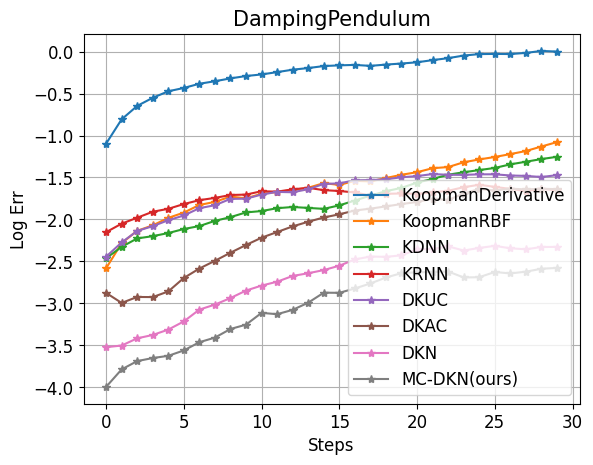

In [63]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',  "#1c1c1f"]
font = {'size'   : 12}

plt.rc('font', **font)
# markers = ['*','+','*','+','*','+','*']
env_name = "DampingPendulum"
# env_name = "CartPole-v1"
# env_name = "MountainCarContinuous-v0"
# env_name = "Pendulum-v1"
# env_name = "Franka"
# env_name = "DoublePendulum"
title = env_name
compare = "max"
# compare = "mean"
for i in range(8):
    index = i
    method = Methods[index]
    if i >= 2:
        file_path = "../Prediction_Results/Compare/"+env_name+"_"+method+"embed.npy"
    else:
        file_path = "../Prediction_Results/Compare/"+env_name+"_"+method+".npy"
    data = np.load(file_path)
    # print(data.shape)
    if compare.startswith("max"):
        plt.plot(np.log10(data[0]),'*-',color = colors[index],label=Method_names[i],linewidth=1.5)
    else:
        plt.plot(np.log10(data[2]),'*-',color = colors[index],label=method)
plt.legend()
# plt.grid(linestyle='-.')
plt.xlabel("Steps",fontsize=12)
plt.ylabel("Log Err",fontsize=12)
plt.grid()
plt.title(title,fontsize=15)
plt.savefig("../Prediction_Results/Prediction/"+env_name+"_"+compare+"_new1.png",dpi=300)